## Plementation

이번 절에서는 fractional differentiation의 두 가지 구현 방법을 알아본다. 하나는 표준적인 expanding window 방법론이고, 다른 하나는 fixed width - window fracdiff라고 부르는 새로운 방법이다.

### Expanding window



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf

start_date = '2000-01-01'
end_date = '2024-04-17'
ticker = 'AAPL'
data = yf.download(
    ticker, 
    start = start_date, 
    end = end_date
)

[*********************100%%**********************]  1 of 1 completed


## Stationarity with Maximum Memory Preservation

Time series $\{X_t\}_{t=1, \dots, T}$를 고려해 보자. Fixing-width window fractional difference 방법을 이 계열에 적용하면 Fractional differentiated Series $\{\tilde X_t\}_{t=l^*, \dots, T}$이 정상성을 가지도록 하는 최소의 차분계수 $d^*$를 구할 수 있다. 이 계수는 정상성을 얻기 위해 없애야 하는 기억의 양을 정량화 한다. $\{\tilde X_t\}_{t=l^*, \dots, T}$가 이미 stationary하다면 $d^*=0$이다

$\{\tilde X_t\}_{t=l^*, \dots, T}$가 unit root을 가지고 있다면 $d^* <1$이다. $\{\tilde X_t\}_{t=l^*, \dots, T}$가 폭발적 행태를 보인다면 $d^* >1$이다. 이 중 $0<d^* <1$인 경우는 원시계열이 약간의 비정상성을 가지는 경우로, 이 경우 정상성을 위해 차분이 필요하지만, 1차 차분을 하게 되면 원시계열에 담겨 있는 market memory와 유의미한 신호를 제거하게 된다

In [2]:
from FinancialMachineLearning.features.fracdiff import FractionalDifferentiatedFeatures

cols = ['adfStat','pVal','lags','nObs','95% conf', 'corr']
out = pd.DataFrame(columns = cols)
for d in np.linspace(0, 1, 21):
    try:
        df1 = data[['Adj Close']]
        df2 = FractionalDifferentiatedFeatures.fracDiff(df1, d = d, thres = 1e-5)
        corr = np.corrcoef(df1.loc[df2.index,'Adj Close'], df2['Adj Close'])[0,1]
        df2 = sm.tsa.stattools.adfuller(df2['Adj Close'], maxlag = 1, regression = 'c', autolag = None)
        out.loc[round(d, 2)] = list(df2[:4]) + [df2[4]['5%']] + [corr]
    except Exception as e:
        print(f'd: {round(d, 2)}, error: {e}')
        continue

d: 0.05, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.1, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.15, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.2, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.25, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors


In [3]:
out

,adfStat,pVal,lags,nObs,95% conf,corr
0.00,0.996045,9.942240e-01,1.0,6107.0,-2.862013,1.000000
0.30,-1.494795,5.360847e-01,1.0,5.0,-3.929280,0.944662
0.35,-1.951754,3.081195e-01,1.0,8.0,-3.367187,0.929395
0.40,-2.291423,1.747490e-01,1.0,12.0,-3.154972,0.897669
0.45,-3.173802,2.155211e-02,1.0,19.0,-3.031227,0.809597
0.50,-3.226918,1.847848e-02,1.0,31.0,-2.960525,0.527159
0.55,-3.855924,2.384258e-03,1.0,50.0,-2.921360,0.478931
0.60,-4.434436,2.578372e-04,1.0,81.0,-2.897943,0.495012
0.65,-4.699271,8.441858e-05,1.0,133.0,-2.883528,0.461179
0.70,-6.629774,5.754012e-09,1.0,223.0,-2.874590,0.405377


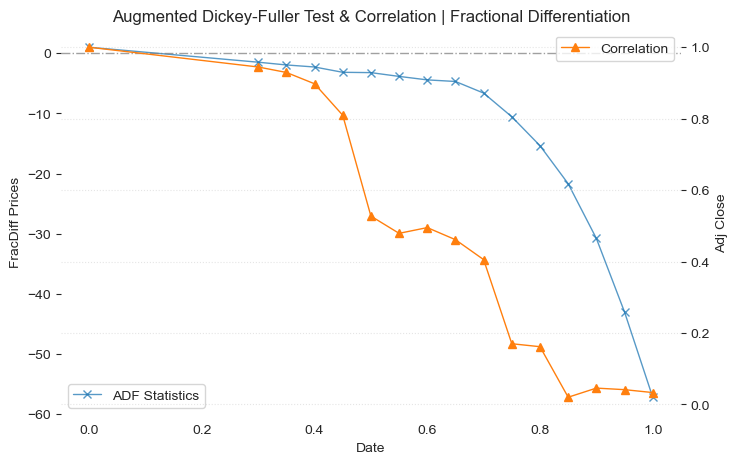

In [71]:
fig, ax1 = plt.subplots(figsize = (8, 5))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('FracDiff Prices')
ax1.plot(out['adfStat'], color=color, alpha=0.75, lw=1, marker = 'x')
ax1.tick_params(axis='y')
ax1.legend(['ADF Statistics'])
ax1.axhline(0, color='gray', alpha=0.75, ls='-.', lw = 1)
ax1.grid(False)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Adj Close')
ax2.plot(out['corr'], color=color, lw=1, alpha=1, marker = '^')
ax2.legend(['Correlation'], loc='upper right')
ax2.tick_params(axis='y')

for spine in ax1.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Augmented Dickey-Fuller Test & Correlation | Fractional Differentiation')

plt.show()

In [5]:
frac_close = FractionalDifferentiatedFeatures.fracDiff(data[['Adj Close']], 0.45)

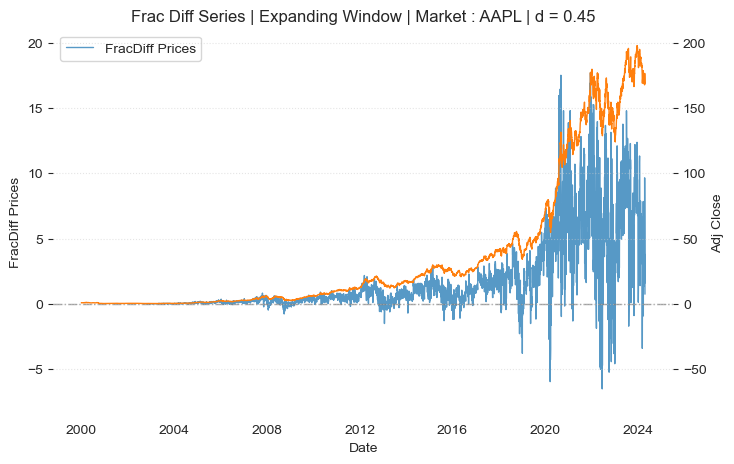

In [43]:
fig, ax1 = plt.subplots(figsize = (8, 5))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('FracDiff Prices')
ax1.plot(frac_close['Adj Close'], color=color, alpha=0.75, lw=1)
ax1.tick_params(axis='y')
ax1.legend(['FracDiff Prices'], loc='upper left')
ax1.set_ylim([-8.5, 21])
ax1.axhline(0, color='gray', alpha=0.75, ls='-.', lw = 1)
ax1.grid(False)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Adj Close')
ax2.plot(data['Adj Close'], color=color, lw=1, alpha=1)
ax2.tick_params(axis='y')
ax2.set_ylim([-85, 210])

for spine in ax1.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Frac Diff Series | Expanding Window | Market : AAPL | d = 0.45')

plt.show()

In [7]:
frac_close_ffd = FractionalDifferentiatedFeatures.fracDiff_FFD(data[['Adj Close']], 0.45)

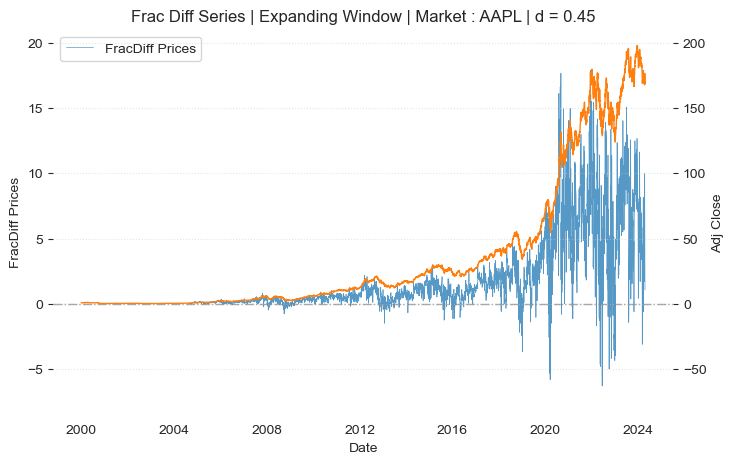

In [50]:
fig, ax1 = plt.subplots(figsize = (8, 5))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('FracDiff Prices')
ax1.plot(frac_close_ffd['Adj Close'], color=color, alpha=0.75, lw=0.5)
ax1.tick_params(axis='y')
ax1.legend(['FracDiff Prices'], loc='upper left')
ax1.set_ylim([-8.5, 21])
ax1.axhline(0, color='gray', alpha=0.75, ls='-.', lw = 1)
ax1.grid(False)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Adj Close')
ax2.plot(data['Adj Close'], color=color, lw=1, alpha=1)
ax2.tick_params(axis='y')
ax2.set_ylim([-85, 210])

for spine in ax1.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Frac Diff Series | Expanding Window | Market : AAPL | d = 0.45')

plt.show()

### ARIMA Fitting

Python에서는 ARFIMA 모형을 적합화하는 모델이 존재하지 않기 때문에, 1이하의 수로 차분된 fracdiff series를 ARIMA 모형에 적합화하여 추정한다. 아래 예제는 AAPL 가격 데이터를 d = 0.45에 맞춘 뒤 추정한 결과이다.

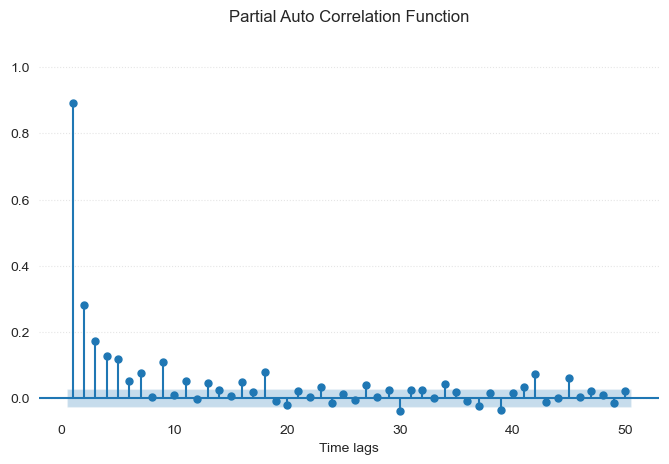

In [72]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize = (8, 5))

plot_pacf(
    frac_close_ffd['Adj Close'], 
    auto_ylims = True, 
    lags = range(1, 51),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.grid(False)
plt.xlabel('Time lags')
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Partial Auto Correlation Function')
plt.show()

ACF 고려하여 MA의 차수도 결정해 준다. Fracdiff series는 memory를 가지고 있기 때문에 포물선 형태가 추정된다. 이런 경우 임의의 수를 지정하여 MA차수를 자른다.

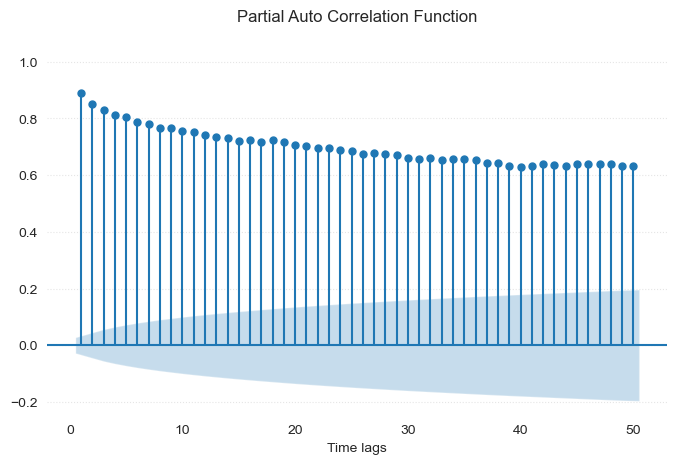

In [73]:
fig, ax = plt.subplots(figsize = (8, 5))

plot_acf(
    frac_close_ffd['Adj Close'], 
    auto_ylims = True, 
    lags = range(1, 51),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.grid(False)
plt.xlabel('Time lags')
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Partial Auto Correlation Function')
plt.show()

아래는 ARFIMA(18, 0.45, 10)을 추정한 결과이다. 컴퓨터 사양에 따라서 작업이 오래 걸릴 수 있으니 실행에 주의하도록 한다.

In [30]:
import warnings
warnings.filterwarnings('ignore')

arima = sm.tsa.ARIMA(
    frac_close_ffd['Adj Close'], 
    order = (18,0,10), 
    trend = 'c'
).fit(method = 'innovations_mle')

In [31]:
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 4948
Model:               ARIMA(18, 0, 10)   Log Likelihood               -8088.947
Date:                Fri, 10 May 2024   AIC                          16237.894
Time:                        00:11:38   BIC                          16433.096
Sample:                             0   HQIC                         16306.346
                               - 4948                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3038      3.479      0.662      0.508      -4.515       9.122
ar.L1          1.7777      0.076     23.401      0.000       1.629       1.927
ar.L2         -2.1038      0.106    -19.883      0.0

잔차에 대한 plot을 그리면 다음과 같다. 

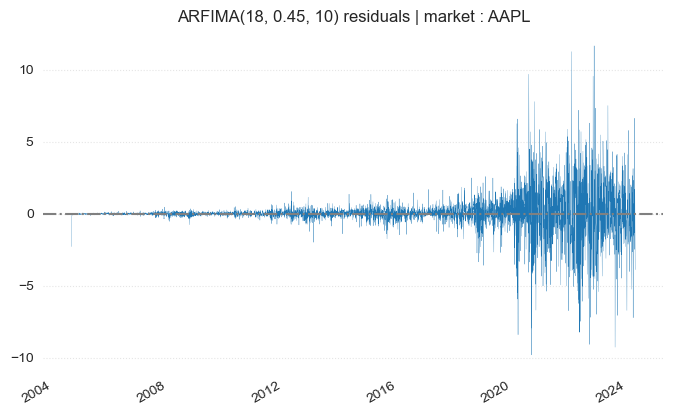

In [46]:
fig, ax = plt.subplots(figsize = (8, 5))
arima.resid.plot(ax = ax, lw = 0.2)
plt.title(f'ARFIMA(18, 0.45, 10) residuals | market : {ticker}')
plt.grid(False)
plt.axhline(0, ls = '-.', color = 'gray')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.show()

시간이 지날수록 잔차가 커지는데, 이는 최근값으로 올수록 long memory가 누적되어서 남아있기 때문이다.